In [62]:
import torch
import torch.nn as nn
import torch.optim as optim
from attentionUnet import *
from model import *
from mae_ssim_loss import MAE_SSIM_Loss
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import numpy as np
from glob import glob
import cv2
import matplotlib.pyplot as plt
import os
from scipy.ndimage import gaussian_filter, map_coordinates

torch.backends.cudnn.benchmark = True





In [63]:
class MyCustomDataset(Dataset):
    def __init__(self,train_path,test_path,image_size=(256, 256),aug=True):
        self.train_path = train_path
        self.test_path = test_path
        self.image_size = image_size
        self.aug = aug

        self.train_images = sorted(glob(os.path.join(train_path, '*.npy')))
    def __len__(self):
        return len(self.train_images)

    def rotate(self,mr,ct):
        
        h, w = self.image_size
        center = (self.image_size[0] // 2, self.image_size[0] // 2)
        angle = np.random.uniform(-10, 10)
        rotation_matrix = cv2.getRotationMatrix2D(center, angle, scale=1.0)
        mr_rotated = cv2.warpAffine(mr, rotation_matrix, (w, h),borderMode=cv2.BORDER_REFLECT_101)
        ct_rotated = cv2.warpAffine(ct, rotation_matrix, (w, h),borderMode=cv2.BORDER_REFLECT_101)
        return mr_rotated,ct_rotated
        
    def hflip(self,mr,ct):
        mr_flipped = cv2.flip(mr, 1)
        ct_flipped = cv2.flip(ct, 1)
        return mr_flipped,ct_flipped

    def scaled(self, mr, ct):
        h, w = self.image_size
    
        # Random scale factor between 0.9 (zoom out) and 1.1 (zoom in)
        scale = np.random.uniform(0.9, 1.1)
    
        # Resize image
        scaled_mr = cv2.resize(mr, None, fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
        scaled_ct = cv2.resize(ct, None, fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
    
        # Get new size
        new_h, new_w = scaled_mr.shape[:2]
    
        # Crop or pad to original size (centered)
        top = max((new_h - h) // 2, 0)
        left = max((new_w - w) // 2, 0)
        bottom = top + h
        right = left + w
    
        # If scaled image is larger — crop center
        if scale >= 1.0:
            scaled_mr = scaled_mr[top:bottom, left:right]
            scaled_ct = scaled_ct[top:bottom, left:right]
        else:
            # If scaled image is smaller — pad to original size
            pad_top = (h - new_h) // 2
            pad_bottom = h - new_h - pad_top
            pad_left = (w - new_w) // 2
            pad_right = w - new_w - pad_left
    
            scaled_mr = cv2.copyMakeBorder(scaled_mr, pad_top, pad_bottom, pad_left, pad_right, borderType=cv2.BORDER_REFLECT_101)
            scaled_ct = cv2.copyMakeBorder(scaled_ct, pad_top, pad_bottom, pad_left, pad_right, borderType=cv2.BORDER_REFLECT_101)
    
        return scaled_mr, scaled_ct
        
    def translate(self, mr, ct):
        h, w = self.image_size
    
        # Max shift: 10% of width and height
        max_shift_x = int(0.1 * w)
        max_shift_y = int(0.1 * h)
    
        # Random shifts in x and y directions
        tx = np.random.randint(-max_shift_x, max_shift_x + 1)
        ty = np.random.randint(-max_shift_y, max_shift_y + 1)
    
        # Create translation matrix
        translation_matrix = np.float32([[1, 0, tx], [0, 1, ty]])
    
        # Apply translation
        mr_translated = cv2.warpAffine(mr, translation_matrix, (w, h), borderMode=cv2.BORDER_REFLECT_101)
        ct_translated = cv2.warpAffine(ct, translation_matrix, (w, h), borderMode=cv2.BORDER_REFLECT_101)
    
        return mr_translated, ct_translated

    def elastic_deformation(self,image, dx, dy):
        shape = image.shape[:2]
    
        x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
        indices = np.reshape(y + dy, (-1)), np.reshape(x + dx, (-1))
    
        if image.ndim == 3:
            channels = []
            for c in range(image.shape[2]):
                channel = map_coordinates(image[..., c], indices, order=1, mode='reflect').reshape(shape)
                channels.append(channel)
            return np.stack(channels, axis=-1).astype(image.dtype)
        else:
            return map_coordinates(image, indices, order=1, mode='reflect').reshape(shape).astype(image.dtype)
    
    def elastic(self, mr, ct, alpha=30, sigma=4):
        shape = mr.shape[:2]
        random_state = np.random.RandomState(None)
    
        dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
        dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    
        mr_deformed = self.elastic_deformation(mr, dx, dy)
        ct_deformed = self.elastic_deformation(ct, dx, dy)
    
        return mr_deformed, ct_deformed

    def augment(self, mr, ct):
        # You can tweak these probabilities (0.5 = 50% chance)
        if np.random.rand() < 0.5:
            mr, ct = self.rotate(mr, ct)
        if np.random.rand() < 0.5:
            mr, ct = self.hflip(mr, ct)
        if np.random.rand() < 0.5:
            mr, ct = self.scaled(mr, ct)
        if np.random.rand() < 0.5:
            mr, ct = self.translate(mr, ct)
        # if np.random.rand() < 0.5:
        #     mr, ct = self.elastic(mr, ct)
    
        return mr, ct
    
    def __getitem__(self, idx):
        mr_path = self.train_images[idx]
        filename = os.path.basename(mr_path)

        # CT file (should match filename)
        ct_path = os.path.join(self.test_path, filename)
        # print(mr_path)
        mr_img = np.load(mr_path)
        ct_img = np.load(ct_path)

        if self.image_size is not None:
            mr_img = cv2.resize(mr_img, self.image_size)
            ct_img = cv2.resize(ct_img, self.image_size)
            
        if self.aug:
            mr_img, ct_img = self.augment(mr_img, ct_img)

        if mr_img.ndim == 2:
            mr_img = np.expand_dims(mr_img, axis=-1)
        if ct_img.ndim == 2:
            ct_img = np.expand_dims(ct_img, axis=-1)



        mr_tensor = torch.from_numpy(mr_img).permute(2, 0, 1).float()
        ct_tensor = torch.from_numpy(ct_img).permute(2, 0, 1).float()

        return mr_tensor, ct_tensor


In [64]:
dataVal = MyCustomDataset('../../ct_mr_stdscale/val/side/mr/','../../ct_mr_stdscale/val/side/ct/',aug=False)
val_loader = DataLoader(dataVal, batch_size=1, shuffle=True)


In [65]:
model = CBAM_UNet().to('cuda')
model.load_state_dict(torch.load('best_model_CBAM_side_new_loss.pth'))

C:\Users\kiw00\AppData\Local\Temp\ipykernel_1472\1792352674.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_CBAM_side_new_lo

<All keys matched successfully>

In [66]:
CLIP_MIN, CLIP_MAX = -1024, 3000

def ct_denorm(norm_data, vmin=CLIP_MIN, vmax=CLIP_MAX):
    data = (norm_data + 1.0) / 2.0 * (vmax - vmin) + vmin
    return data.astype(np.float32)

In [67]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchmetrics.functional import structural_similarity_index_measure as ssim
from torchmetrics.functional import peak_signal_noise_ratio as psnr

CLIP_MIN, CLIP_MAX = -1024, 3000

def ct_denorm(norm_data, vmin=CLIP_MIN, vmax=CLIP_MAX):
    data = (norm_data + 1.0) / 2.0 * (vmax - vmin) + vmin
    return data.astype(np.float32)


def inference(model, val_loader, checkpoint="best_model_side.pth"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # model = model.to(device)

    # Load best weights
    # model.load_state_dict(torch.load(checkpoint, map_location=device))
    model.eval()

    # ---- Take 1 batch ----
    imgs, targets = next(iter(val_loader))
    imgs, targets = imgs.to(device), targets.to(device)

    # ---- Predict ----
    with torch.no_grad():
        preds = model(imgs)

    # ---- Move numpy ----
    img_np = imgs[0].cpu().numpy().squeeze()
    target_np = targets[0].cpu().numpy().squeeze()
    pred_np = preds[0].cpu().numpy().squeeze()

    # ---- Denormalize ----
    img_denorm = ct_denorm(img_np)
    tgt_denorm = ct_denorm(target_np)
    pred_denorm = ct_denorm(pred_np)

    # ------------------------------------------------------------------
    # 🔥 Compute SSIM & PSNR (use normalized tensors, not HU images)
    # ------------------------------------------------------------------
    with torch.no_grad():
        # reshape for torchmetrics: (B, C, H, W)
        pred_t = preds[0].unsqueeze(0)
        tgt_t = targets[0].unsqueeze(0)

        ssim_score = ssim(pred_t, tgt_t)
        psnr_score = psnr(pred_t, tgt_t, data_range=2.0)  # input is normalized to [-1,1]

    print("=================================")
    print(f"SSIM : {ssim_score.item():.4f}")
    print(f"PSNR : {psnr_score.item():.4f} dB")
    print("=================================")

    # ---- Visualize ----
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title("Input MRI")
    plt.imshow(img_denorm, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth CT")
    plt.imshow(tgt_denorm, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Predicted CT")
    plt.imshow(pred_denorm, cmap='gray')
    plt.axis('off')

    plt.show()

    return pred_denorm, ssim_score.item(), psnr_score.item()


SSIM : 0.8827
PSNR : 31.0699 dB


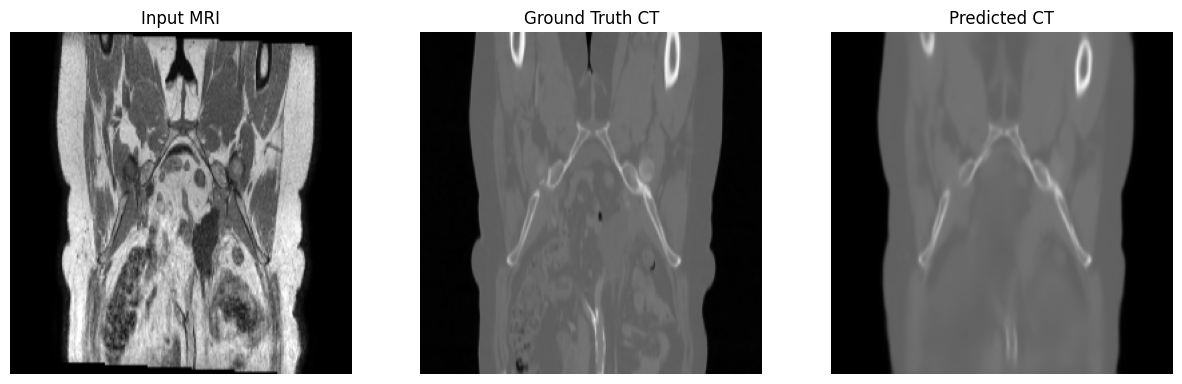

In [91]:
pred = inference(model, val_loader)